In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
import json

# Plot about the theorems in mathlib4

In [2]:
from pipeline.config import REPO
from pipeline.utils.theorem_extraction import theorem_names_from_blob
from pipeline.utils.git_extraction import get_all_blobs
from git import Tree

In [103]:
# print the (approximate) current number of theorems in reference repository
all_subdir = [tree.path for tree in REPO.head.commit.tree["Mathlib"] if isinstance(tree, Tree)]
commit = list(REPO.iter_commits(rev="master"))[0]
total_n = sum([len(theorem_names_from_blob(blob)) for blob in get_all_blobs(commit.tree["Mathlib"])])
print(f"Total number of theorems in Mathlib4 (approx.) at commit {commit.hexsha}: {total_n}")

Total number of theorems in Mathlib4 (approx.) at commit a261710852a957a7d20d89b962e4b59887549f21: 120612


In [14]:
print("Number of theorems by directory (approx.):")
for subdir in all_subdir:
    theorem_counts = []
    blob_theorem_counts = [len(theorem_names_from_blob(blob)) for blob in get_all_blobs(commit.tree[subdir])]
    print(f"{subdir.replace('Mathlib/', '', 1)}: {sum(blob_theorem_counts)}")

Number of theorems by directory (approx.):
Algebra: 19334
AlgebraicGeometry: 1336
AlgebraicTopology: 336
Analysis: 13165
CategoryTheory: 6389
Combinatorics: 2176
Computability: 985
Condensed: 7
Control: 187
Data: 19301
Deprecated: 189
Dynamics: 403
FieldTheory: 1284
Geometry: 2381
GroupTheory: 2967
InformationTheory: 52
Init: 304
Lean: 5
LinearAlgebra: 5522
Logic: 1461
Mathport: 0
MeasureTheory: 7040
ModelTheory: 701
NumberTheory: 2862
Order: 9539
Probability: 1682
RepresentationTheory: 214
RingTheory: 6322
SetTheory: 2568
Tactic: 545
Testing: 7
Topology: 11344
Util: 4


In [101]:
# retrieve only one commit from each month
unique_month_commits = []
commit_months = []
for commit in REPO.iter_commits(rev="master"):
    if commit.committed_datetime.strftime("%Y-%m") in commit_months:
        continue
    else:
        commit_months.append(commit.committed_datetime.strftime("%Y-%m"))
        unique_month_commits.append(commit)

In [104]:
# obtain an approximated total number of theorems by sub-directories of mathlib4
theorem_counts_by_sub_dir = {}
for subdir in all_subdir:
    theorem_counts = []
    for commit in unique_month_commits:
        try:
            blob_theorem_counts = [len(theorem_names_from_blob(blob)) for blob in get_all_blobs(commit.tree[subdir])]
            theorem_counts.append(sum(blob_theorem_counts))
        except KeyError:
            theorem_counts.append(0)
    theorem_counts_by_sub_dir[subdir.replace("Mathlib/", "", 1)] = theorem_counts

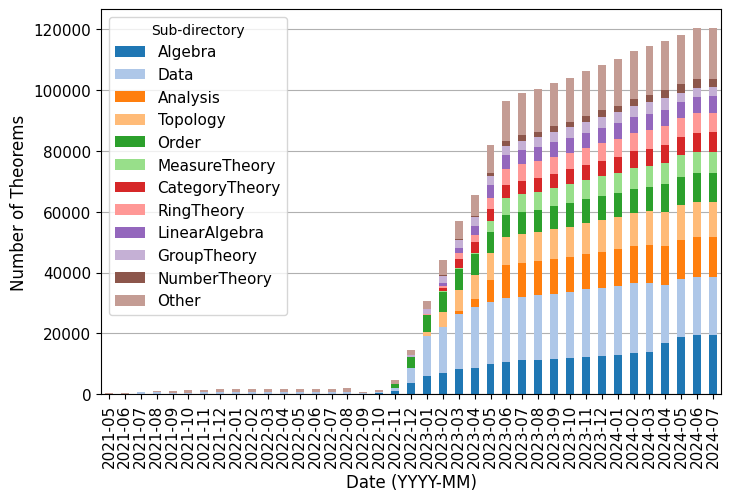

In [109]:
theorem_counts_df = pd.DataFrame(theorem_counts_by_sub_dir, index=commit_months).iloc[::-1]
top_sub_dir = [pair[0] for pair in sorted(theorem_counts_df.iloc[-1].items(), key=lambda x: x[-1], reverse=True)[:11]]
theorem_counts_df["Other"] = sum(theorem_counts_df[col] for col in theorem_counts_df.columns if col not in top_sub_dir) 
filtered_df = theorem_counts_df[top_sub_dir+["Other"]]

# set colours
num_colors = len(filtered_df.columns)
colors = sns.color_palette("tab20", num_colors)

ax = filtered_df.plot(kind='bar', stacked=True, color=colors, figsize=(8, 5))
plt.xlabel('Date (YYYY-MM)', fontsize=12)
plt.ylabel('Number of Theorems', fontsize=12)

# configure legend
plt.legend(title='Sub-directory', loc='best', ncol=1, fontsize=11)

plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
ax.grid(True, axis='y')
ax.set(axisbelow=True)
plt.show()

# Examine the application of the tracer

In [142]:
import time
start_time = time.time()
# trace entire mathlib4 using the tracer
!python -m pipeline.tracer.trace -d Mathlib
print(f"Time taken to trace entire Mathlib using Mac M2 Chip: {time.time() - start_time}")

STARTING: Lean repo copy creation
DONE: Lean repo copy creation
STARTING: retrieve cache
Attempting to download 4738 file(s)lease
Downloaded: 4738 file(s) [attempted 4738/4738 = 100%] (100% success)
Decompressing 4738 file(s)
Unpacked in 5562 ms
Completed successfully!
DONE: retrieved cache
Begin to retrieve theorem name from Mathlib.Tactic
Begin to retrieve theorem name from Mathlib.Algebra.AddTorsor
Begin to retrieve theorem name from Mathlib.Algebra.AlgebraicCard
Begin to retrieve theorem name from Mathlib.Algebra.Associated
Begin to retrieve theorem name from Mathlib.Algebra.Bounds
Begin to retrieve theorem name from Mathlib.Algebra.CubicDiscriminant
Begin to retrieve theorem name from Mathlib.Algebra.DirectLimit
Begin to retrieve theorem name from Mathlib.Algebra.DualNumber
Begin to retrieve theorem name from Mathlib.Algebra.DualQuaternion
Begin to retrieve theorem name from Mathlib.Algebra.Exact
Begin to retrieve theorem name from Mathlib.Algebra.Expr
Begin to retrieve theorem na

In [52]:
# print total number of theorems and files considered by the data scraping
from pipeline.config import TRACED_INFO_DIR

num_theorems = 0
num_files = 0
for file_name in os.listdir(TRACED_INFO_DIR):
    file = os.path.join(TRACED_INFO_DIR, file_name)
    num_files += 1
    with open(file, "r") as json_file:
        num_theorems += len(json.load(json_file))

print(f"Number of theorems considered in the data scraping: {num_theorems}.")
print(f"Number of files considered in the data scraping: {num_files}.")

Number of theorems considered in the data scraping: 148507.
Number of files considered in the data scraping: 4443.


# Pre-process the mathlib4 dataset after scraping

In [55]:
from pipeline.config import RAW_DATA_DIR

num_theorems = 0
num_files = 0
for file_name in os.listdir(RAW_DATA_DIR):
    file = os.path.join(RAW_DATA_DIR, file_name)
    with open(file, "r") as json_file:
        raw_data = json.load(json_file)
    raw_data_thm = set(raw_data["thm_name"])
    if len(raw_data_thm) > 0:
        num_files += 1
    num_theorems += len(raw_data_thm)
    
print(f"Number of theorems remaining after the data scraping: {num_theorems}.")
print(f"Number of files remaining after the data scraping: {num_files}.")

Number of theorems remaining after the data scraping: 5549.
Number of files remaining after the data scraping: 1645.


In [2]:
# preprocess the data
!python -m pipeline.scraper.preprocess -v

Beginning pre-processing with 90900 raw data points.
Removed 148 data points from containing empty values.
Removed 81834 data points from duplicacy.
STARTING: Lean repo copy creation
DONE: Lean repo copy creation
STARTING: retrieve cache
Attempting to download 4738 file(s)
Downloaded: 4738 file(s) [attempted 4738/4738 = 100%] (100% success)
Decompressing 4738 file(s)
Unpacked in 5087 ms
Completed successfully!
DONE: retrieved cache
STARTING: Lean repo copy removal
DONE: Lean repo copy removal
Removed 42 invalid data points after verification.
8876 data points remaining after pre-processing.


In [3]:
# generate the data splits for training
!python -m pipeline.scraper.split -d proof_repair_dataset.csv -r # split randomly
!python -m pipeline.scraper.split -d proof_repair_dataset.csv # split by file

Spliting the data randomly.
Number of training data = 6876.
Number of validation data = 1000.
Number of test data = 1000.
Spliting the data by file.
Number of training data = 6876.
Number of validation data = 1000.
Number of test data = 1000.


# Explore basic characteristics about the full mathlib4 proof repair dataset

In [3]:
df = pd.read_csv("pipeline/scraper/processed_data/mathlib4_repair.csv")
df.head()

,filepath,thm_name,decl_name,commit,failed_proof,error_msg,statement,proof
0,Mathlib/Algebra/AddTorsor.lean,Equiv.injective_pointReflection_left_of_inject...,injective_pointReflection_left_of_injective_bit0,9b791e01d76723bff4dded1502953e20ad5647b1,:=\n fun x₁ x₂ (hy : pointReflection x₁ y = p...,warning: `bit0` has been deprecated\nwarning:...,theorem injective_pointReflection_left_of_inje...,:=\n fun x₁ x₂ (hy : pointReflection x₁ y = p...
1,Mathlib/Algebra/AddTorsor.lean,Equiv.pointReflection_fixed_iff_of_injective_bit0,pointReflection_fixed_iff_of_injective_bit0,b0c1460c9fd4a5058bcae6b919686bc5e8a0ee37,":= by\n rw [pointReflection_apply, eq_comm, e...",error: unknown tactic\nwarning: `bit0` has b...,theorem pointReflection_fixed_iff_of_injective...,":= by\n rw [pointReflection_apply, eq_comm, e..."
2,Mathlib/Algebra/Algebra/Hom.lean,RingHom.toIntAlgHom_injective,toIntAlgHom_injective,997e544cc107a670c989a8e6943e61e19978185e,:=\n fun _ _ e ↦ FunLike.ext _ _ (fun x ↦ Fun...,warning: AlgHom does not have a doc string\nw...,lemma toIntAlgHom_injective [Ring R] [Ring S] ...,:=\n fun _ _ e ↦ DFunLike.ext _ _ (fun x ↦ DF...
3,Mathlib/Algebra/Algebra/Quasispectrum.lean,spectrum_subset_quasispectrum,spectrum_subset_quasispectrum,596865180ecc63dcd1d95809202e31027ac3ae38,:=\n quasispectrum_eq_spectrum_union R a ▸ Se...,error: function expected at\n Set.subset_uni...,lemma spectrum_subset_quasispectrum (R : Type*...,:=\n quasispectrum_eq_spectrum_union R a ▸ Se...
4,Mathlib/Algebra/Algebra/Spectrum.lean,spectrum.units_smul_resolvent_self,units_smul_resolvent_self,3a31aabe59645ce291dedbcbdd3f949a56d5178f,":= by\n simpa only [Units.smul_def, Algebra.i...",error: function expected at\n units_smul_res...,theorem units_smul_resolvent_self {r : Rˣ} {a ...,":= by\n simpa only [Units.smul_def, Algebra.i..."


In [57]:
# print basic information about the columns
print(f"Number of samples = {len(df)}")
print(f"Number of unique theorems included = {len(df.thm_name.unique())}")
print(f"Number of unique files included = {len(df.filepath.unique())}")
print(f"Number of unique commits included = {len(df.commit.unique())}")

Number of samples = 8876
Number of unique theorems included = 5489
Number of unique files included = 1637
Number of unique commits included = 1905


In [81]:
# look at file distribution
parent_dir = df.filepath.apply(lambda x: x.split("/")[1])
dir_keys = parent_dir.value_counts().keys()[::-1]
dir_counts = parent_dir.value_counts().values[::-1]

In [79]:
# look at file distribution
parent_dir = df.filepath.apply(lambda x: x.split("/")[1])
dir_keys = parent_dir.value_counts().keys()[::-1]
dir_counts = parent_dir.value_counts().values[::-1]

# plot the distribution in the time of each data point
from pipeline.utils.git_extraction import file_commits

all_commits = file_commits()
def commit_date(commit):
    try:
        commit_idx = [c.hexsha for c in all_commits].index(commit)
    except ValueError:
        return np.nan
    return all_commits[commit_idx].committed_datetime

commit_dates = df.commit.apply(commit_date)
commit_dates = commit_dates.dropna() 
commit_dates = pd.Series([t.strftime('%Y-%m') for t in commit_dates])
commit_dates = commit_dates.value_counts().sort_index()
all_months = pd.date_range(start=commit_dates.index[0], end=commit_dates.index[-1], freq='MS').strftime('%Y-%m').tolist()

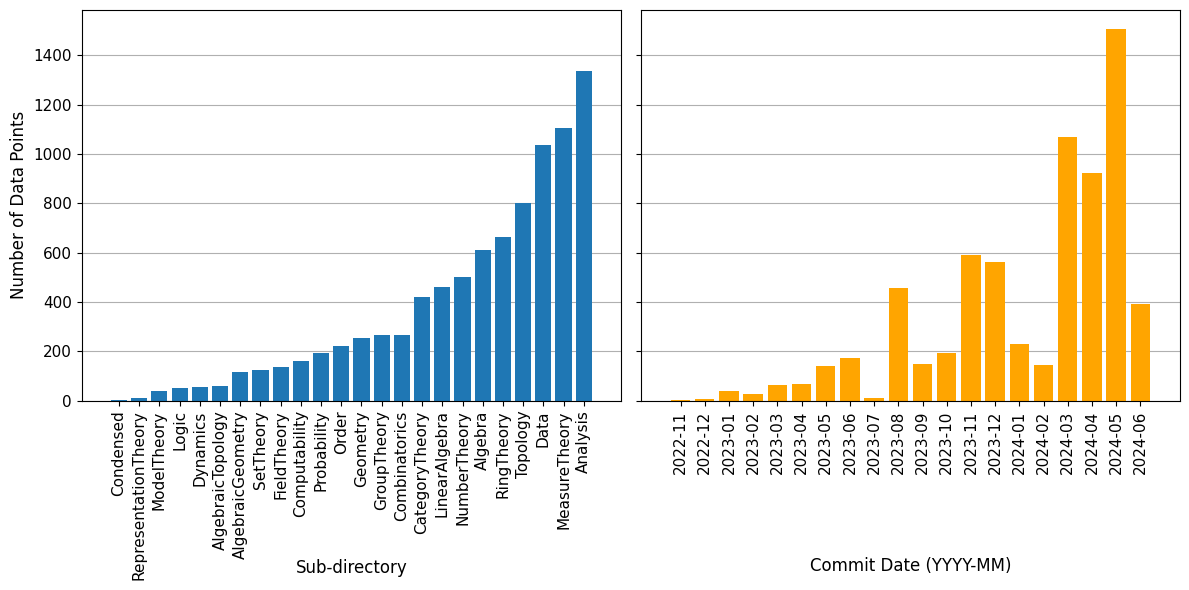

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
ax[0].bar(dir_keys, dir_counts)
ax[0].tick_params(labelsize=11)
ax[0].set_xticks(range(len(dir_keys)))  
ax[0].set_xticklabels(dir_keys, rotation=90)  
ax[0].set_xlabel("Sub-directory", fontsize=12, labelpad=-15)
ax[0].set_ylabel("Number of Data Points", fontsize=12)
ax[0].tick_params(axis='y') 
ax[0].grid(True, axis='y')
xmin, xmax = ax[0].get_xlim()
ax[0].set(xlim=(xmin-0.25, xmax+0.25), axisbelow=True)


counts = [0 for _ in range(len(all_months))]
for i, m in enumerate(commit_dates.index):
    j = all_months.index(m)
    counts[j] = commit_dates.values[i]
ax[1].bar(all_months, counts, color="orange")
ax[1].tick_params(labelsize=11)
ax[1].set_xlabel("Commit Date (YYYY-MM)", fontsize=12, labelpad=60)
ax[1].grid(True, axis='y')
xmin, xmax = ax[1].get_xlim()
ax[1].set(xlim=(xmin-0.25, xmax+0.25), axisbelow=True)
ax[1].set_xticks(range(len(all_months)))  
ax[1].set_xticklabels(all_months, rotation=90)
plt.tight_layout()

plt.show()

In [128]:
# retrieve basic statistic on the lengths
proof_len = df.proof.apply(len)
failed_proof_len = df.failed_proof.apply(len)
statement_len = df.statement.apply(len)
error_len = df.error_msg.apply(len)

len_df = pd.DataFrame({'Proof': proof_len, 'Failed Proof': failed_proof_len, 'Statement': statement_len, "Error Message": error_len, "Statement+Proof": proof_len+2*statement_len+error_len})
len_df.describe(percentiles=[.05, .25, .5, .75, .95])

,Proof,Failed Proof,Statement,Error Message,Statement+Proof
count,8876.000000,8876.000000,8876.000000,8876.000000,8876.000000
mean,916.950879,929.998310,158.857706,510.171924,1744.838215
std,1176.846880,1190.393543,96.187183,891.631709,1719.691389
min,2.000000,2.000000,26.000000,22.000000,133.000000
5%,43.000000,37.000000,58.000000,38.000000,331.000000
25%,165.000000,169.000000,91.000000,117.000000,657.000000
50%,465.000000,480.000000,136.000000,281.000000,1176.000000
75%,1180.250000,1204.500000,197.000000,586.000000,2205.000000
95%,3285.000000,3313.500000,342.000000,1661.250000,5264.000000
max,6924.000000,7824.000000,827.000000,20311.000000,25563.000000


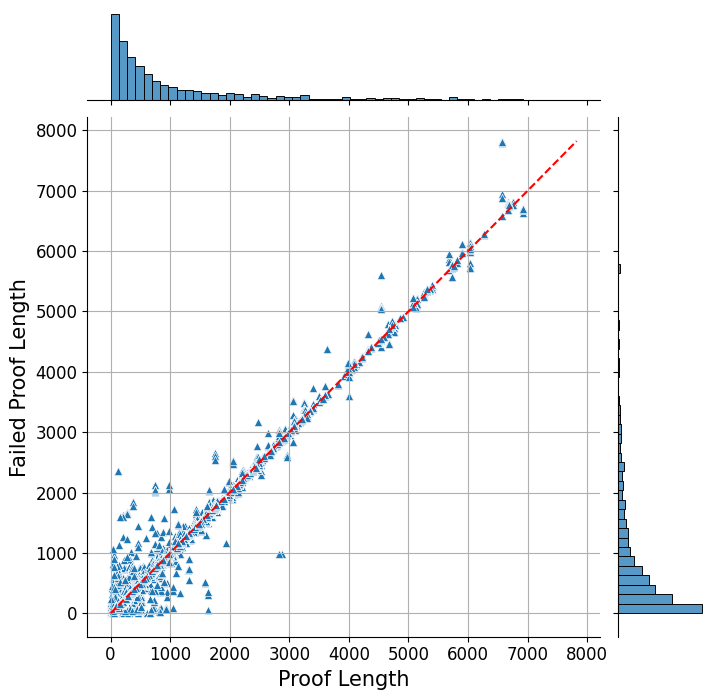

In [142]:
# plot the lengths of the proofs and failed proofs
proof_len = df.proof.apply(len)
failed_proof_len = df.failed_proof.apply(len)

fig = sns.jointplot(x=proof_len, y=failed_proof_len, kind="scatter", marginal_kws=dict(bins=50, fill=True), marker='^', height=7, ratio=5)

fig.ax_joint.grid(True, zorder=0)
fig.ax_joint.collections[0].set_zorder(1)

fig.ax_joint.set_xlabel('Proof Length', fontsize=15)
fig.ax_joint.set_ylabel('Failed Proof Length', fontsize=15)

fig.ax_joint.tick_params(axis='both', labelsize=12) 

min_val = min(proof_len.min(), failed_proof_len.min())
max_val = max(proof_len.max(), failed_proof_len.max())
fig.ax_joint.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", zorder=2)

plt.show()

In [144]:
# consider the correlation between difference in proof length with proof length itself
print(f"Correlation coefficient between proof length and its absolute difference with the length of the failed proof: {proof_len.corr((failed_proof_len-proof_len).abs())}" )

Correlation coefficient between proof length and its absolute difference with the length of the failed proof: 0.08491880003495363


# Explore similarity of theorems between subdirectories and files

In [34]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Compute embeddings for each theorem
subdir_df = df.copy()
subdir_df["subdir"] = subdir_df.filepath.apply(lambda x: x.split("/")[1])
subdir_df["whole_theorem"] = subdir_df["statement"] + subdir_df["proof"]
model = SentenceTransformer("flax-sentence-embeddings/st-codesearch-distilroberta-base")
embeddings = model.encode(subdir_df.whole_theorem.values)

# cacluate the similarity scores between embeddings
similarity_scores = cosine_similarity(embeddings)

/opt/miniconda3/envs/ReProver/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/opt/miniconda3/envs/ReProver/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
def similarity_scores_by_group(df, similarity_scores, group, min_n_samples=2):
    values_counts = df[group].value_counts()
    unique_groups = values_counts[values_counts >= min_n_samples].keys()
    n_groups = len(unique_groups)
    similarity_scores_grouped = np.ones((n_groups, n_groups))

    for i, group_x in tqdm(enumerate(unique_groups)):
        group_x_indices = np.array(df.index[df[group] == group_x])

        for j, group_y in enumerate(unique_groups[i:]):
            k = j + i
            group_y_indices = np.array(df.index[df[group] == group_y])
            x_y_similarity_scores = similarity_scores[group_x_indices[:, None], group_y_indices]
            if i == k and len(x_y_similarity_scores) > 1:
                # ignore the comparison with own self to avoid skewing the averaging
                mask = np.ones((len(x_y_similarity_scores), len(x_y_similarity_scores)), dtype=bool)
                np.fill_diagonal(mask, 0)
                similarity_scores_grouped[i, k] = x_y_similarity_scores[mask].mean()
            else:
                similarity_scores_grouped[i, k] = x_y_similarity_scores.mean()
    similarity_scores_grouped[np.tril_indices(n_groups, -1)] = similarity_scores_grouped.T[np.tril_indices(n_groups, -1)]
    return similarity_scores_grouped

24it [00:00, 82.13it/s]


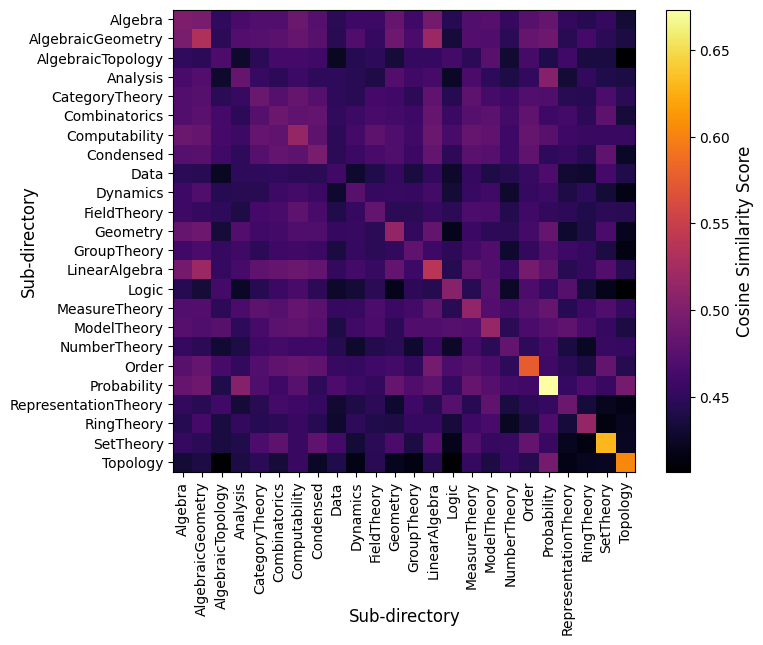

In [36]:
similarity_scores_by_subdir = similarity_scores_by_group(subdir_df, similarity_scores, "subdir")
unique_subdir = subdir_df.subdir.unique()
plt.figure(figsize=(8, 6))
plt.imshow(similarity_scores_by_subdir, cmap='inferno')
cbar = plt.colorbar(label='Cosine Similarity Score')
cbar.ax.yaxis.label.set_size(12)
cbar.ax.tick_params(labelsize=10) 
plt.xticks(ticks=np.arange(len(unique_subdir)), labels=unique_subdir, rotation=90, fontsize=10)
plt.yticks(ticks=np.arange(len(unique_subdir)), labels=unique_subdir, fontsize=10)
plt.xlabel('Sub-directory', fontsize=12, labelpad=-20)
plt.ylabel('Sub-directory', fontsize=12, labelpad=-20)
plt.show()

In [136]:
i = 22
print(df.statement.values[i]+df.proof.values[i])
print()
print(df.statement.values[i]+df.failed_proof.values[i])

theorem finprod_mem_finset_product' [DecidableEq α] [DecidableEq β] (s : Finset (α × β))
    (f : α × β → M) :
    (∏ᶠ (ab) (_ : ab ∈ s), f ab) =
      ∏ᶠ (a) (b) (_ : b ∈ (s.filter fun ab => Prod.fst ab = a).image Prod.snd), f (a, b) := by
  have (a) :
      ∏ i ∈ (s.filter fun ab => Prod.fst ab = a).image Prod.snd, f (a, i) =
        (s.filter (Prod.fst · = a)).prod f := by
    refine Finset.prod_nbij' (fun b ↦ (a, b)) Prod.snd ?_ ?_ ?_ ?_ ?_ <;> aesop
  rw [finprod_mem_finset_eq_prod]
  simp_rw [finprod_mem_finset_eq_prod, this]
  rw [finprod_eq_prod_of_mulSupport_subset _
      (s.mulSupport_of_fiberwise_prod_subset_image f Prod.fst),
    ← Finset.prod_fiberwise_of_maps_to (t := Finset.image Prod.fst s) _ f]
  simp only [Finset.mem_image]
  exact fun x hx => ⟨x, hx, rfl⟩

theorem finprod_mem_finset_product' [DecidableEq α] [DecidableEq β] (s : Finset (α × β))
    (f : α × β → M) :
    (∏ᶠ (ab) (_ : ab ∈ s), f ab) =
      ∏ᶠ (a) (b) (_ : b ∈ (s.filter fun ab => Prod.fst ab = a).imag

In [50]:
# compare similarity scores between being from the same sub-directory or different sub-directory
similarity_scores_by_subdir = similarity_scores_by_group(subdir_df, similarity_scores, "subdir")
mask = np.ones((len(similarity_scores_by_subdir), len(similarity_scores_by_subdir)), dtype=bool)
np.fill_diagonal(mask, 0)
print(f"Average cosine similarity score between theorems from different sub-directories = {similarity_scores_by_subdir[mask].mean()}±{similarity_scores_by_subdir[mask].std()}")
print(f"Average cosine similarity score between theorems from same sub-directory = {similarity_scores_by_subdir[~mask].mean()}±{similarity_scores_by_subdir[~mask].std()}")

24it [00:00, 71.96it/s]

Average cosine similarity score between theorems from different sub-directories = 0.45595330637002335±0.018167533850914488
Average cosine similarity score between theorems from same sub-directory = 0.5173857683936754±0.052095518995659354


In [51]:
# perform statistical test to test for the difference in mean
from scipy import stats

_, subdir_p_value = stats.ttest_ind(similarity_scores_by_subdir[mask], similarity_scores_by_subdir[~mask], alternative="less", equal_var=False)
print(f"p-value from the t-test that the mean similarity score between theorems from different sub-directories is less than the mean similarity score between theorems from the same sub-directory: {subdir_p_value}")

p-value from the t-test that the mean similarity score between theorems from different sub-directories is less than the mean similarity score between theorems from the same sub-directory: 4.6531323038837564e-06


In [38]:
similarity_scores_by_file = similarity_scores_by_group(df, similarity_scores, "filepath", 10)

259it [00:08, 31.90it/s] 


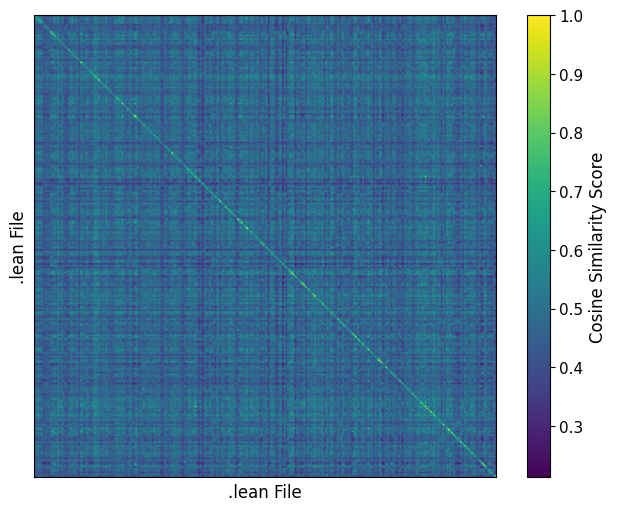

In [39]:
unique_files = df.filepath.unique()
plt.figure(figsize=(8, 6))
plt.imshow(similarity_scores_by_file, cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Cosine Similarity Score', fontsize=12)  # Adjust font size here
cbar.ax.tick_params(labelsize=11)
plt.xlabel('.lean File', fontsize=12)
plt.ylabel('.lean File', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.show()

In [40]:
# compare similarity scores between being from the same file or different file
similarity_scores_by_file = similarity_scores_by_group(df, similarity_scores, "filepath", 2)
mask = np.ones((len(similarity_scores_by_file), len(similarity_scores_by_file)), dtype=bool)
np.fill_diagonal(mask, 0)
print(f"Average cosine similarity score between theorems from different files = {similarity_scores_by_file[mask].mean()}±{similarity_scores_by_file[mask].std()}")
print(f"Average cosine similarity score between theorems from same file = {similarity_scores_by_file[~mask].mean()}±{similarity_scores_by_file[~mask].std()}")

1209it [02:55,  6.91it/s]

Average cosine similarity score between theorems from different files = 0.4616213641000239±0.07104762124283345
Average cosine similarity score between theorems from same file = 0.783143249225577±0.1502332985381355


In [49]:
# perform statistical test to test for the difference in mean
_, by_file_p_value = stats.ttest_ind(similarity_scores_by_file[mask], similarity_scores_by_file[~mask], alternative="less", equal_var=False)
print(f"p-value from the t-test that the mean similarity score between theorems from different files is less than the mean similarity score between theorems from the same file: {by_file_p_value}")

p-value from the t-test that the mean similarity score between theorems from different files is less than the mean similarity score between theorems from the same file: 0.0


In [12]:
# identify the most common substrings in the error messages
from collections import Counter
from itertools import zip_longest

def get_most_common_phrases(error_msg_ls, k):
    phrase_counter = Counter()
    
    for error_msg in error_msg_ls:
        words = error_msg.split()  # Split the string into words
        
        if len(words) >= k:
            for i in range(len(words) - k + 1):
                phrase = " ".join(words[i:i + k])
                phrase_counter[phrase] += 1
    
    # Find the most common substrings
    return phrase_counter.most_common()
    
substrings_counts = []
max_len = 10
for substring_len in range(max_len):

    substrings_counts.append(get_most_common_phrases(df.error_msg.values, substring_len+1))
substring_counts_df = pd.DataFrame((x for x in zip_longest(*substrings_counts)), columns=[x+1 for x in range(max_len)])

In [54]:
# most common length 5 substrings in error message
substring_counts_df[5].values[:10]

array([('is expected to have type', 2351),
       ('but is expected to have', 2349),
       (': Prop but is expected', 1660),
       ('Prop but is expected to', 1660),
       ('error: simp made no progress', 1311),
       ('warning: `bit0` has been deprecated', 1222),
       ('warning: `bit1` has been deprecated', 1162),
       ('`bit0` has been deprecated warning:', 1144),
       ('does not have a doc', 1114), ('not have a doc string', 1114)],
      dtype=object)

In [30]:
# most common length 10 substrings in error message
substring_counts_df[10].values[:10]

array([('invalid field notation, type is not of the form (C', 898),
       ('field notation, type is not of the form (C ...)', 898),
       ('notation, type is not of the form (C ...) where', 898),
       ('type is not of the form (C ...) where C', 898),
       ('is not of the form (C ...) where C is', 898),
       ('not of the form (C ...) where C is a', 898),
       ('of the form (C ...) where C is a constant', 898),
       ('error: invalid field notation, type is not of the form', 872),
       ("error: tactic 'rewrite' failed, did not find instance of the", 859),
       ("tactic 'rewrite' failed, did not find instance of the pattern", 859)],
      dtype=object)

# Compare data splits

In [143]:
random_data = {
    "train": pd.read_csv("pipeline/scraper/processed_data/random/train.csv"),
    "valid": pd.read_csv("pipeline/scraper/processed_data/random/valid.csv"),
    "test": pd.read_csv("pipeline/scraper/processed_data/random/test.csv"),
}

by_file_data = {
    "train": pd.read_csv("pipeline/scraper/processed_data/by_file/train.csv"),
    "valid": pd.read_csv("pipeline/scraper/processed_data/by_file/valid.csv"),
    "test": pd.read_csv("pipeline/scraper/processed_data/by_file/test.csv"),
}

In [84]:
# compare distribution over lengths
def plot_length_distributions(data, col):
    lengths = {
        key: data[key][col].apply(len)
        for key in data
    }

    # Create a DataFrame for plotting
    length_df = pd.DataFrame(lengths)
    length_df = length_df.melt(var_name='Split', value_name='Length')

    # Plot KDE
    plt.figure(figsize=(8, 6))
    ax = sns.kdeplot(data=length_df, x='Length', hue='Split', fill=True, common_norm=False, legend=True)
    plt.xlabel('Proof Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlim((0, None))
    legend = ax.get_legend()
    legend.set_title('Split', prop={'size': 12})  # Optionally set the title size
    for text in legend.get_texts():
        text.set_fontsize(12)  # Change the fontsize here to your preferred size

    return ax

<Axes: xlabel='Proof Length', ylabel='Density'>

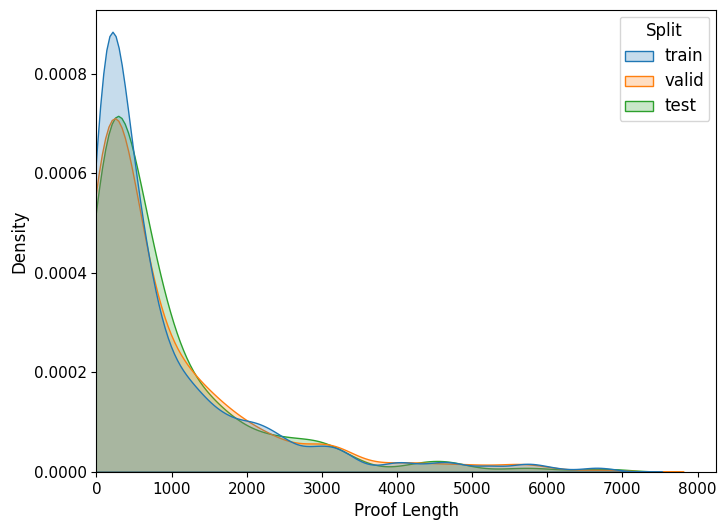

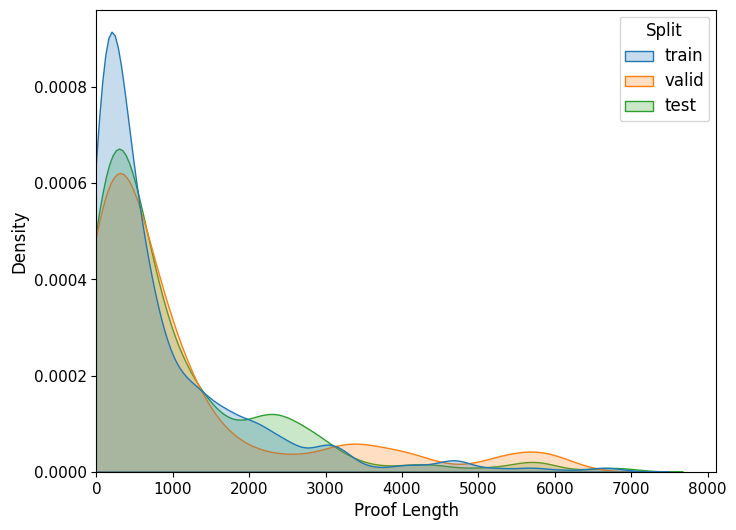

In [147]:
plot_length_distributions(random_data, "proof")
plot_length_distributions(by_file_data, "proof")

# Invalid data point

In [152]:
# identify potential data points that may in fact contain other theorems
for idx, p in enumerate(df.failed_proof.values):
    if "theorem" in p:
        print("-----" + str(idx))
        print(p)
        print("------------")
        print()

-----1216
:= by
  set g : ℂ → F := f ∘ fun t : ℂ => t • (w - z) + z
  suffices g 0 = g 1 by simpa
  apply liouville_theorem_aux
  exacts [hf.comp ((differentiable_id.smul_const (w - z)).add_const z),
    hb.subset (range_comp_subset_range _ _)]
------------

-----2051
:= by
  have h_nonneg : (0 : ℝ) ≤ ((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2 := sq_nonneg _
  have g : HasSum (fun k : ℕ => (((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2) ^ ↑(k + 1))
      (((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2 / (1 - ((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2)) := by
    have := (hasSum_geometric_of_lt_one h_nonneg ?_).mul_left (((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2)
    · simp_rw [← _root_.pow_succ'] at this
      exact this
    rw [one_div, inv_pow]
    exact inv_lt_one (one_lt_pow ((lt_add_iff_pos_left 1).mpr <| by positivity) two_ne_zero)
  have hab (k : ℕ) : (1 : ℝ) / (2 * ↑(k + 1) + 1) * ((1 / (2 * ↑(n + 1) + 1)) ^ 2) ^ ↑(k + 1) ≤
      (((1 : ℝ) / (2 * ↑(n + 1) + 1)) ^ 2) ^ ↑(k + 1) := by
    refine mul_le_of_le_one_left (pow_no